In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [44]:
import tensorflow as tf
from tensorflow import lite

# Pre-processing of the images
We will be training a VGG-19 model on our custom training dataset to classify among the 5 categories-Phoma, Cescospora, Rust, Healthy, and Miners. The dataset must all be resized to the required dimension.

While resizing the images, let us also derive x_train,x_test,x_val,y_train,y_test and y_val hand-in-hand. These terms can be described in a nutshell as follows:

- **x_train**: Numpy arrays of the images of the training dataset
- **y_train**: Labels of the training dataset
- **x_test**: Numpy arrays of the images of the testing dataset
- **y_test**: Labels of the testing dataset
- **x_val**: Numpy arrays of the images of the validation dataset
- **y_val**: Labels of the validation dataset

In [7]:
train_path="./Dataset4/train"
test_path="./Dataset4/test"
val_path="./Dataset4/val"

In [12]:
IMG_SIZE = (128,128)

def pre_proc_images(file_path):
    file_list=[]
    for folder in os.listdir(file_path):
        sub_path=file_path+"/"+folder
        for img in os.listdir(sub_path):
            image_path=sub_path+"/"+img
            img_arr=cv2.imread(image_path)
            img_arr=cv2.resize(img_arr,IMG_SIZE)
            file_list.append(img_arr)
    norm_file = np.array(file_list)/255.0
    return norm_file

def ImgDataGen(file_path):    
    file_datagen = ImageDataGenerator(rescale = 1./255)
    file_set = file_datagen.flow_from_directory(file_path,
                                                target_size = IMG_SIZE,
                                                batch_size = 32,
                                                class_mode = 'sparse')
    return file_set


In [13]:
train_x, test_x, val_x = pre_proc_images(train_path), pre_proc_images(test_path), pre_proc_images(val_path)

In [15]:
training_set, test_set, val_set = ImgDataGen(train_path), ImgDataGen(test_path), ImgDataGen(val_path)

Found 1636 images belonging to 5 classes.
Found 239 images belonging to 5 classes.
Found 465 images belonging to 5 classes.


In [16]:
train_y, test_y, val_y = training_set.classes, test_set.classes, val_set.classes

In [20]:
train_y.shape,test_y.shape,val_y.shape

((1636,), (239,), (465,))

In [21]:
train_x.shape,test_x.shape,val_x.shape

((1636, 128, 128, 3), (239, 128, 128, 3), (465, 128, 128, 3))

In [18]:
training_set.class_indices

{'Cerscospora': 0, 'Healthy': 1, 'Leaf rust': 2, 'Miner': 3, 'Phoma': 4}

In [23]:
vgg = VGG19(input_shape= [128,128] + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 25s 0us/step


In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)

In [26]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [27]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

#Early stopping to avoid overfitting of model

In [29]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
52/52 [==============================] - 230s 4s/step - loss: 0.5794 - accuracy: 0.8032 - val_loss: 0.2145 - val_accuracy: 0.9505
Epoch 2/10
52/52 [==============================] - 234s 5s/step - loss: 0.1621 - accuracy: 0.9584 - val_loss: 0.1475 - val_accuracy: 0.9720
Epoch 3/10
52/52 [==============================] - 202s 4s/step - loss: 0.1026 - accuracy: 0.9762 - val_loss: 0.1188 - val_accuracy: 0.9785
Epoch 4/10
52/52 [==============================] - 202s 4s/step - loss: 0.0672 - accuracy: 0.9896 - val_loss: 0.1112 - val_accuracy: 0.9742
Epoch 5/10
52/52 [==============================] - 212s 4s/step - loss: 0.0505 - accuracy: 0.9933 - val_loss: 0.0930 - val_accuracy: 0.9806
Epoch 6/10
52/52 [==============================] - 220s 4s/step - loss: 0.0393 - accuracy: 0.9963 - val_loss: 0.0835 - val_accuracy: 0.9871
Epoch 7/10
52/52 [==============================] - 244s 5s/step - loss: 0.0297 - accuracy: 0.9982 - val_loss: 0.0819 - val_accuracy: 0.9871
Epoch 8/10
52

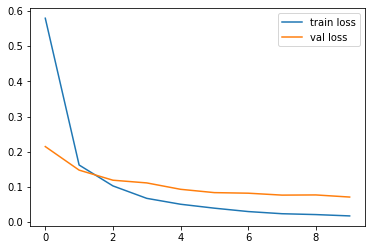

In [30]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

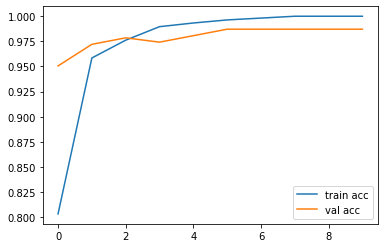

In [31]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [32]:
model.evaluate(test_x,test_y,batch_size=32)

8/8 [==============================] - 26s 3s/step - loss: 0.0708 - accuracy: 0.9791


[0.07082363963127136, 0.9790794849395752]

In [33]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [35]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

In [36]:
accuracy_score(y_pred,test_y)

0.9790794979079498

In [38]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      0.99        78
           2       1.00      1.00      1.00        34
           3       0.97      0.97      0.97        69
           4       0.89      0.92      0.91        26

    accuracy                           0.98       239
   macro avg       0.97      0.98      0.97       239
weighted avg       0.98      0.98      0.98       239



In [39]:
confusion_matrix(y_pred,test_y)

array([[32,  0,  0,  0,  0],
       [ 0, 77,  0,  0,  1],
       [ 0,  0, 34,  0,  0],
       [ 0,  0,  0, 67,  2],
       [ 0,  0,  0,  2, 24]], dtype=int64)

# Export the Model

In [45]:
keras_file = "Desease_control_model.h5"
tf.keras.models.save_model(model,keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open("Desease_control_model.tflite","wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ALIZAW~1\AppData\Local\Temp\tmpe1dh8l2_\assets


80270636